In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Activation, Add, GlobalAveragePooling2D 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import math
import seaborn as sns
import numpy as np
import os
import cv2
import shutil
import pandas as pd

In [3]:
# silence warnings
import warnings
warnings.filterwarnings('ignore')
import absl.logging as absl_logging

# Set the logging level to suppress debug messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
absl_logging.get_absl_logger().setLevel('ERROR')

In [4]:
# setup for multiple outputs from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The goal of this project is to construct an image classification system using a TensorFlow neural network to classify four common aquarium fish species. As a first step, 100 images were collected for each of the four species listed below. For each original image, 6 new transformed or processed versions were created:

1-- Original image version (size: 300 x 300)  
2-- Original image version rotated 30 degrees counterclockwise (size: 300 x 300)  
3-- Original image version rotated 30 degrees clockwise  (size: 300 x 300)  
4-- Horizontally flipped version (size: 300 x 300)  
5-- Horizontally flipped version rotated 30 degrees counterclockwise (size: 300 x 300)  
6-- Horizontally flipped version rotated 30 degrees clockwise (size: 300 x 300)  

THE FOUR FISH SPECIES:



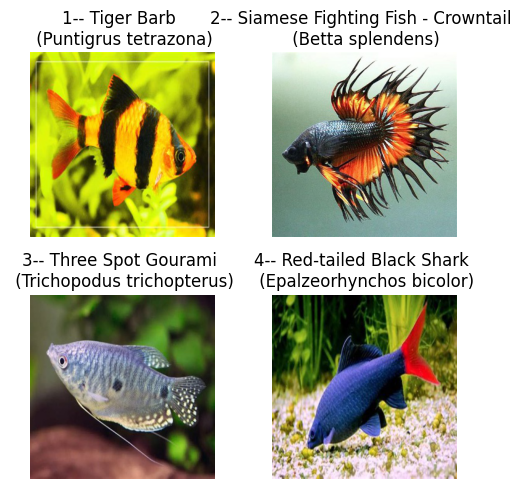

In [142]:
# Display the four fish species
# This script's ("Tensorflow_Aquarium_Fish_Image_Classification.ipynb") directory to provide 
#   relative location of folder ('Pics') holding pictures
# Adjust this line to reflect any new location 
location_of_this_ipynb_file = '/media/ijmg/SSD_FOUR_TB/ACADEMICS_101/MY_PROJECTS/ADDED_PROJECTS/Fish/'

# Paths to images (in relative folder 'Pics') and their associated labels
path_to_barb_pic = os.path.join(location_of_this_ipynb_file, 'Pics/barb_001.jpeg')
path_to_betta_pic = os.path.join(location_of_this_ipynb_file, 'Pics/betta_001.jpeg')
path_to_gourami_pic = os.path.join(location_of_this_ipynb_file, 'Pics/gourami_001.jpeg')
path_to_redtail_pic = os.path.join(location_of_this_ipynb_file, 'Pics/redtail_001.jpeg')
image_paths = [path_to_barb_pic, path_to_betta_pic, path_to_gourami_pic, path_to_redtail_pic]
labels = ['1-- Tiger Barb \n (Puntigrus tetrazona)', 
          '2-- Siamese Fighting Fish - Crowntail \n (Betta splendens)', 
          '3-- Three Spot Gourami \n (Trichopodus trichopterus)', 
          '4-- Red-tailed Black Shark \n (Epalzeorhynchos bicolor)']

# Number of images to display in the grid
num_images = len(image_paths)

# Set up the subplot grid
num_rows = 2
num_cols = 2

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))

# Iterate over the images and labels
for i, (image_path, label) in enumerate(zip(image_paths, labels)):
    # Load and display the image
    img = mpimg.imread(image_path)
    
    # Determine the subplot index
    row_index = i // num_cols
    col_index = i % num_cols
    
    # Plot the image and set the title
    axes[row_index, col_index].imshow(img)
    axes[row_index, col_index].set_title(label)
    
    # Remove axis ticks
    axes[row_index, col_index].axis('off')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
print('THE FOUR FISH SPECIES:\n')
plt.show();

In [6]:
# A function to create a variety of standardized, transformed training set images from a set of 100 
#    original images
# Function arguments: species name, list of image file names, input folder, output folder
# Each original base input image will be replaced by 6 new tramsformed training images:
# 1-- Original image version (size: 300 x 300)
# 2-- Original image version rotated 30 degrees counterclockwise (size: 300 x 300)
# 3-- Original image version rotated 30 degrees clockwise (size: 300 x 300)
# 4-- Horizontally flipped version (size: 300 x 300)
# 5-- Horizontally flipped version rotated 30 degrees counterclockwise (size: 300 x 300)
# 6-- Horizontally flipped version rotated 30 degrees clockwise (size: 300 x 300) 
#
# After utilizing the image_transformer function, each species will have approximately 600 training 
#     set images
def image_transformer(species_name, image_list, input_folder, output_folder):
    count = 0
    base_name = str(species_name)
    file_type = '.jpeg'
    for image in image_list:      
        num_id = str(count).zfill(3)
        # extract image
        img = cv2.imread(input_folder + str(image))

        # resize image
        count = count + 1
        num_id = str(count).zfill(3)
        x_dim = 300
        y_dim = 300
        new_size = (x_dim, y_dim)
        img_resized = cv2.resize(img, new_size, interpolation= cv2.INTER_LINEAR)
        cv2.imwrite(os.path.join( output_folder + base_name + num_id + file_type ), img_resized) 
        
        # flip and save resized image
        count = count + 1
        num_id = str(count).zfill(3)
        img_flip = cv2.flip(img_resized, 1)
        cv2.imwrite( os.path.join(output_folder + base_name + num_id + file_type), img_flip)
        
        # rotate both resized original and resized, flipped original  +30 and -30 degrees then save images
        (h, w) = img_resized.shape[:2]
        center = (w / 2, h / 2)
        angle_1 = 30
        angle_2 = -30
        scale = 1
        M_1 = cv2.getRotationMatrix2D(center, angle_1, scale)
        img_rot_pos30 = cv2.warpAffine(img_resized, M_1, (w, h))
        count = count + 1
        num_id = str(count).zfill(3)
        cv2.imwrite( os.path.join(output_folder + base_name + num_id + file_type), img_rot_pos30)           
        
        M_2 = cv2.getRotationMatrix2D(center, angle_2, scale)
        img_rot_neg30 = cv2.warpAffine(img_resized, M_2, (w, h))
        count = count + 1
        num_id = str(count).zfill(3)
        cv2.imwrite( os.path.join(output_folder + base_name + num_id + file_type), img_rot_neg30)        
        
        M_1 = cv2.getRotationMatrix2D(center, angle_1, scale)
        img_rot_pos30 = cv2.warpAffine(img_flip, M_1, (w, h))
        count = count + 1
        num_id = str(count).zfill(3)
        cv2.imwrite( os.path.join(output_folder + base_name + num_id + file_type), img_rot_pos30)           
        
        M_2 = cv2.getRotationMatrix2D(center, angle_2, scale)
        img_rot_neg30 = cv2.warpAffine(img_flip, M_2, (w, h))
        count = count + 1
        num_id = str(count).zfill(3)
        cv2.imwrite( os.path.join(output_folder + base_name + num_id + file_type), img_rot_neg30)

In [7]:
# A function to create directories if they do not exist
# This function will create directories holding the transformed images
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    else:
        pass

In [8]:
# OBTAIN LIST OF ORIGINAL IMAGES
# Each species of fish has its own folder holding original images
# Folders are located relative to this file ("Tensorflow_Aquarium_Fish_Image_Classification.ipynb")
barb_original_folder = os.path.join(location_of_this_ipynb_file, 'original_images/original_barbs/')
betta_original_folder = os.path.join(location_of_this_ipynb_file, 'original_images/original_bettas/')
gourami_original_folder = os.path.join(location_of_this_ipynb_file, 'original_images/original_gouramis/')
redtail_original_folder = os.path.join(location_of_this_ipynb_file, 'original_images/original_redtails/')
# Read original image names for each species into a unique image list
barb_original_image_list = os.listdir(barb_original_folder)
betta_original_image_list = os.listdir(betta_original_folder)
gourami_original_image_list = os.listdir(gourami_original_folder)
redtail_original_image_list = os.listdir(redtail_original_folder)

In [9]:
# PREPARE TRANSFORMED IMAGES
# Each species of fish has its own folder holding transformed images
# Folders are located relative to this file ("Tensorflow_Aquarium_Fish_Image_Classification.ipynb")
barb_transformed_folder = os.path.join(location_of_this_ipynb_file, 'transformed_images/barbs/')
betta_transformed_folder = os.path.join(location_of_this_ipynb_file, 'transformed_images/bettas/')
gourami_transformed_folder = os.path.join(location_of_this_ipynb_file, 'transformed_images/gouramis/')
redtail_transformed_folder = os.path.join(location_of_this_ipynb_file, 'transformed_images/redtails/')
create_directory(barb_transformed_folder)
create_directory(betta_transformed_folder)
create_directory(gourami_transformed_folder)
create_directory(redtail_transformed_folder)
# Send each species original image list to the image_transformer function to make new image training versions
# For each function call, four parameters are passed:
# 1.) species base name for naming sequential images (i.e. "barb001.jpeg", "barb002.jpeg" ... etc.),
# 2.) base imput image list of original 100 base input images, 
# 3.) input directory holding original 100 base input images for each species, and
# 4.) output directory where expanded output training images will be written for each species
image_transformer('barbs_', barb_original_image_list, barb_original_folder, barb_transformed_folder)
image_transformer('bettas_', betta_original_image_list, betta_original_folder, betta_transformed_folder)
image_transformer('gouramis_', gourami_original_image_list, gourami_original_folder, gourami_transformed_folder)
image_transformer('redtails_', redtail_original_image_list, redtail_original_folder, redtail_transformed_folder)
# This resulted in roughly 600 images for each of the fish species. 
# These images are in the transformed_images folder

In [104]:
# The 600 images for each fish species was then divided between a training set (roughly 80%) 
#     and a test set (roughly 20%).
# Specify path to dataset
dataset_path = location_of_this_ipynb_file + 'transformed_images/'

# Create ImageDataGenerator for splitting dataset
# ImageDataGenerator was used to add even more variety to the training set images
data_generator = ImageDataGenerator(
rescale=1./255,         # Normalize pixel values to [0, 1]
validation_split=0.20)  # 20% for validation (test) set

train_generator = data_generator.flow_from_directory(
    dataset_path,  
    shuffle=True,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


test_generator = data_generator.flow_from_directory(
    dataset_path, 
    shuffle=False,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1920 images belonging to 4 classes.
Found 480 images belonging to 4 classes.


In [11]:
# Show the four class labels 
print("Train set class labels:", train_generator.class_indices)
print("Test set class labels:",test_generator.class_indices)

# Show the class indices, class labels and class values
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
class_values = list(class_indices.values())

print(class_indices)
print(class_labels)
print(class_values)

Train set class labels: {'barbs': 0, 'bettas': 1, 'gouramis': 2, 'redtails': 3}
Test set class labels: {'barbs': 0, 'bettas': 1, 'gouramis': 2, 'redtails': 3}
{'barbs': 0, 'bettas': 1, 'gouramis': 2, 'redtails': 3}
['barbs', 'bettas', 'gouramis', 'redtails']
[0, 1, 2, 3]


In [12]:
# Count the number of images for each class
# Dictionaries to hold class counts
image_count_per_train_class = {label: 0 for label in class_labels}
image_count_per_test_class = {label: 0 for label in class_labels}

# Load each dictionary with class counts
for class_label in train_generator.classes:
    class_name = class_labels[class_label]
    image_count_per_train_class[class_name] += 1
    
for class_label in test_generator.classes:
    class_name = class_labels[class_label]
    image_count_per_test_class[class_name] += 1

# Print the image count for each class
print('\nTraining Image Class Counts:')
for class_name, count in image_count_per_train_class.items():
    print(f'{class_name}: {count} images')
print('\nTest Image Class Counts:')
for class_name, count in image_count_per_test_class.items():
    print(f'{class_name}: {count} images')


Training Image Class Counts:
barbs: 480 images
bettas: 480 images
gouramis: 480 images
redtails: 480 images

Test Image Class Counts:
barbs: 120 images
bettas: 120 images
gouramis: 120 images
redtails: 120 images


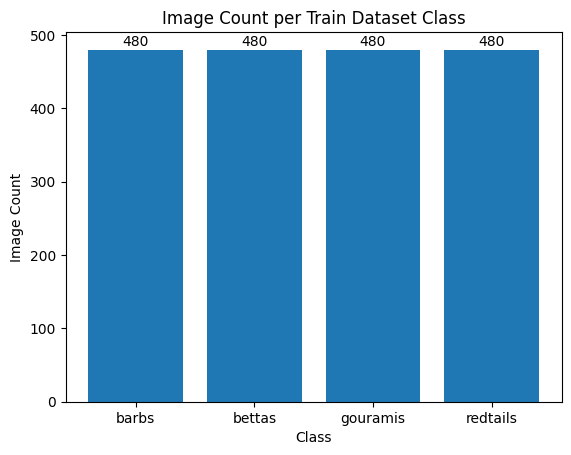

In [13]:
# Image count in each train dataset class
# Plot the bar chart of image count in each train class
fig, ax = plt.subplots()
ax.bar(image_count_per_train_class.keys(), image_count_per_train_class.values())
# Add numeric values at the top of each bar
for i, value in enumerate(image_count_per_train_class.values()):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
ax.set_xlabel('Class')
ax.set_ylabel('Image Count')
ax.set_title('Image Count per Train Dataset Class')
plt.show();

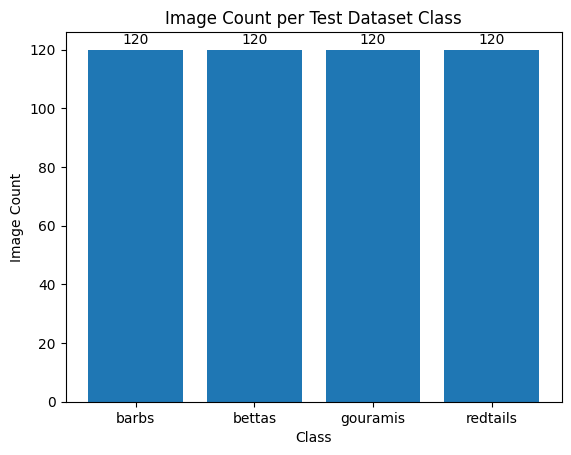

In [14]:
# Image count in each test dataset class
# Plot the bar chart of image count in each test class (slightly different method)
categories = image_count_per_test_class.keys()
values = image_count_per_test_class.values()
plt.bar(categories, values)
# Add numeric values at the top of each bar
for i, value in enumerate(image_count_per_test_class.values()):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
# Add labels and title 
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Image Count per Test Dataset Class')
# Display the plot
plt.show();

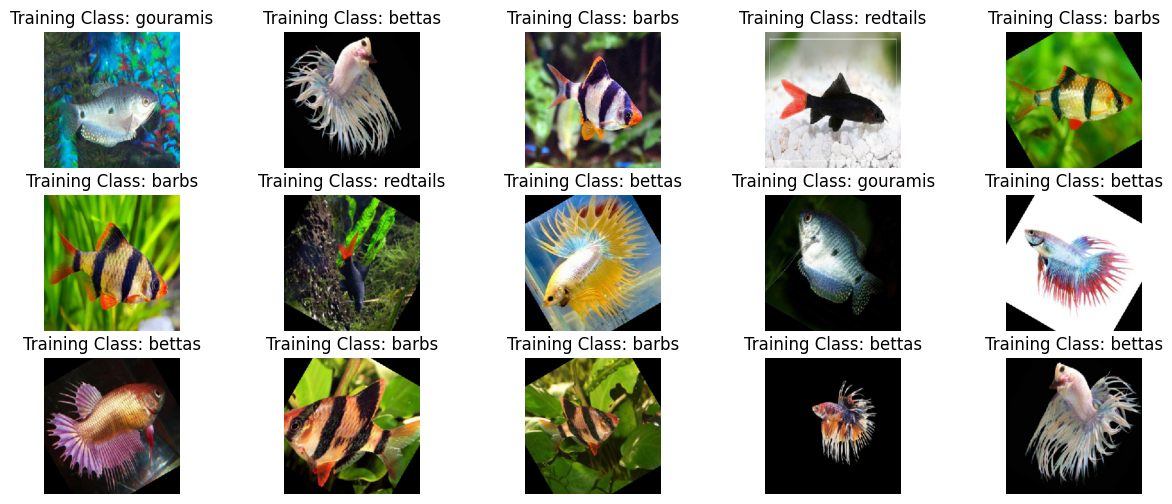

In [15]:
# Display sample of 15 random images from the training dataset
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

for i in range(15):
    random_image, label = train_generator.next()
    class_name = list(train_generator.class_indices.keys())[np.argmax(label)]
    axes[i//5, i%5].imshow(random_image[0])
    axes[i//5, i%5].set_title(f'Training Class: {class_name}')
    axes[i//5, i%5].axis('off')

plt.show();

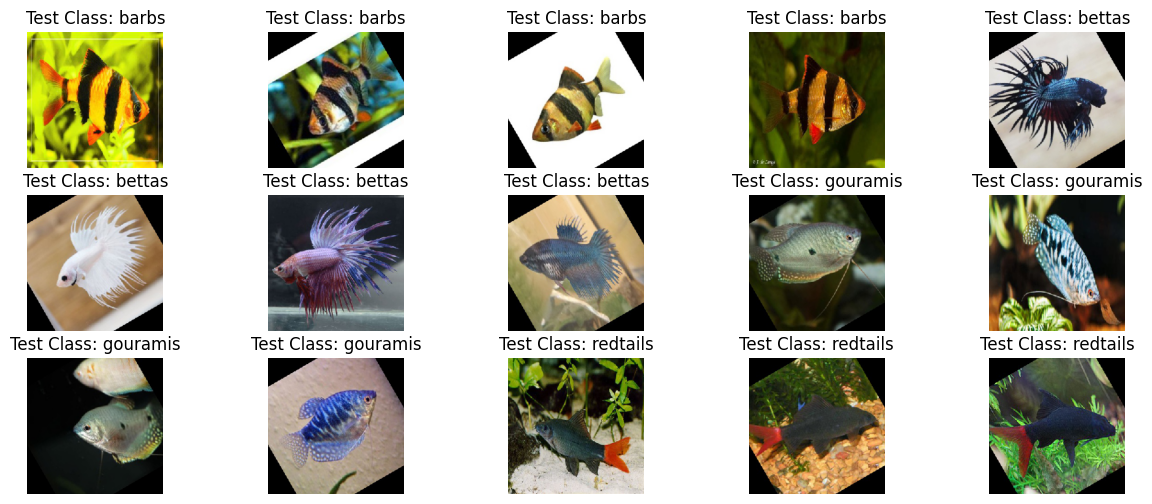

In [16]:
# Display sample of 15 random images from the test dataset
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

for i in range(15):
    random_image, label = test_generator.next()
    class_name = list(test_generator.class_indices.keys())[np.argmax(label)]
    axes[i//5, i%5].imshow(random_image[0])
    axes[i//5, i%5].set_title(f'Test Class: {class_name}')
    axes[i//5, i%5].axis('off')

plt.show();

In [17]:
# Two different models will be compared:
# -- a general tensorflow model
# -- a Googlenet tensorflow model
# Each model will be tested with and without crossfold validation
# The model with the best performance (accuracy) will be reported more fully in terms of
#    number of images mislabeled and display of mislabeled images

In [18]:
# ---------------------------------------------------
# ---------------------------------------------------
# IMAGE CLASSIFICATION WITH GENERAL TENSORFLOW MODEL
# ---------------------------------------------------
# ---------------------------------------------------

In [141]:
# Function to define general model
def build_model(num_classes):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', 
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [21]:
# Define number of classes
Num_classes = 4
# Create the general model
general_model = build_model(Num_classes)

In [22]:
# Compile Model
general_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['accuracy'])
# Train the model
general_model_history = general_model.fit(train_generator, epochs=20 )

Epoch 1/20


2024-03-06 11:25:39.516062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 38s 619ms/step - loss: 1.2631 - accuracy: 0.4120
Epoch 2/20
60/60 [==============================] - 38s 633ms/step - loss: 0.9854 - accuracy: 0.5932
Epoch 3/20
60/60 [==============================] - 41s 676ms/step - loss: 0.7839 - accuracy: 0.6740
Epoch 4/20
60/60 [==============================] - 40s 662ms/step - loss: 0.6456 - accuracy: 0.7521
Epoch 5/20
60/60 [==============================] - 40s 673ms/step - loss: 0.5627 - accuracy: 0.7797
Epoch 6/20
60/60 [==============================] - 39s 650ms/step - loss: 0.4561 - accuracy: 0.8323
Epoch 7/20
60/60 [==============================] - 39s 643ms/step - loss: 0.3831 - accuracy: 0.8604
Epoch 8/20
60/60 [==============================] - 40s 667ms/step - loss: 0.3240 - accuracy: 0.8833
Epoch 9/20
60/60 [==============================] - 39s 643ms/step - loss: 0.2820 - accuracy: 0.9104
Epoch 10/20
60/60 [==============================] - 42s 696ms/step - loss: 0.2434 - accuracy: 0.9172


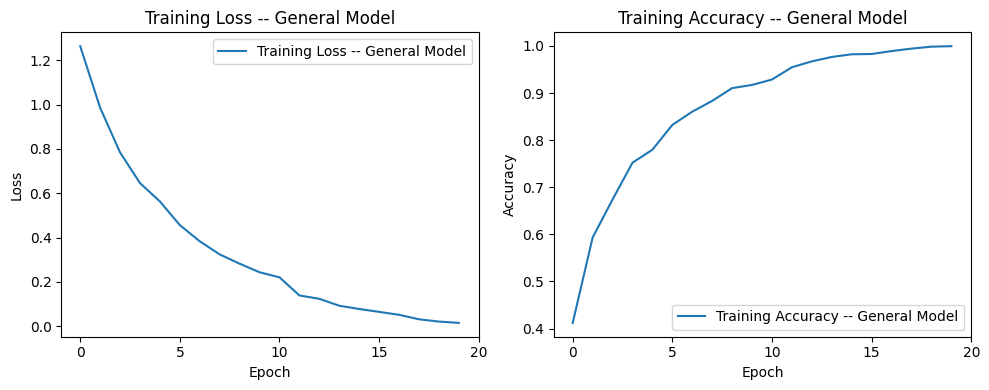

In [72]:
# Plot the training set loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(general_model_history.history['loss'], label='Training Loss -- General Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss -- General Model')
plt.xticks(np.linspace(0, 20, 5))
plt.legend()


# Plot the training set accuracy
plt.subplot(1, 2, 2)
plt.plot(general_model_history.history['accuracy'], label='Training Accuracy -- General Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy -- General Model')
plt.xticks(np.linspace(0, 20, 5))
plt.legend()

plt.tight_layout();
plt.show();

In [24]:
# Evaluate the model on the test set
general_model_predictions = general_model.predict(test_generator)

2024-03-06 11:43:07.848742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 2s 131ms/step


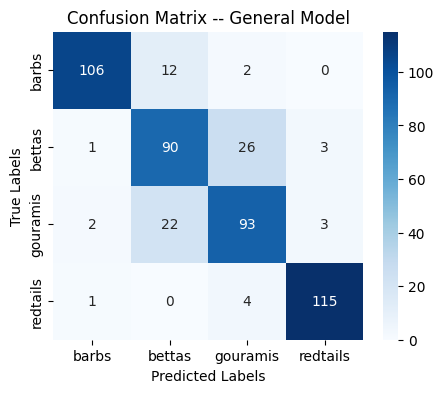

In [105]:
# Create confusion matrix
general_model_predicted_labels = np.argmax(general_model_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, general_model_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- General Model')
plt.show();

In [26]:
# Count mislabeled images
# Get class names from folder names
class_names = sorted(os.listdir(dataset_path))

# Get true labels
true_labels = test_generator.classes

# Get predicted labels
general_model_predicted_labels = np.argmax(general_model_predictions, axis=1)

# Find mislabeled indices
general_mislabeled_indices = np.where(true_labels != general_model_predicted_labels)[0]

print("Number of mislabeled images:", len(general_mislabeled_indices))
print("Number of predictions:", len(general_model_predictions))
print("Overall accuracy:", round((1- (len(general_mislabeled_indices)/len(general_model_predictions)))*100, 2), "percent" )


Number of mislabeled images: 76
Number of predictions: 480
Overall accuracy: 84.17 percent


In [27]:
# ---------------------------------------------------
# ---------------------------------------------------
# IMAGE CLASSIFICATION WITH GOOGLENET TENSORFLOW MODEL
# ---------------------------------------------------
# ---------------------------------------------------

In [140]:
# Functions to define Googlenet model
def inception_module(x, filters):
    # 1x1 convolution
    conv1x1_1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 convolution followed by 3x3 convolution
    conv1x1_2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_2)

    # 1x1 convolution followed by 5x5 convolution
    conv1x1_3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_3)

    # 3x3 max pooling followed by 1x1 convolution
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate all branches
    inception = Concatenate(axis=-1)([conv1x1_1, conv3x3, conv5x5, conv1x1_4])
    return inception

def googlenet():
    input_layer = Input(shape=(224, 224, 3))

    # Initial convolution layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, [64, 128, 128, 32, 32, 32])
    x = inception_module(x, [128, 192, 96, 64, 64, 64])

    # Additional inception modules...

    # Fully connected layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    x = Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=x, name='googlenet')
    return model

In [29]:
# Create Googlenet model
google_model = googlenet()

In [30]:
# Compile model 
google_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['accuracy'])
# Train the model
google_history = google_model.fit(train_generator, epochs=20 )

Epoch 1/20


2024-03-06 11:45:26.970374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 475s 8s/step - loss: 1.3274 - accuracy: 0.3620
Epoch 2/20
60/60 [==============================] - 459s 8s/step - loss: 1.0719 - accuracy: 0.5703
Epoch 3/20
60/60 [==============================] - 470s 8s/step - loss: 0.9076 - accuracy: 0.6427
Epoch 4/20
60/60 [==============================] - 474s 8s/step - loss: 0.7956 - accuracy: 0.6932
Epoch 5/20
60/60 [==============================] - 480s 8s/step - loss: 0.6950 - accuracy: 0.7349
Epoch 6/20
60/60 [==============================] - 480s 8s/step - loss: 0.5862 - accuracy: 0.7839
Epoch 7/20
60/60 [==============================] - 486s 8s/step - loss: 0.5238 - accuracy: 0.8151
Epoch 8/20
60/60 [==============================] - 486s 8s/step - loss: 0.4792 - accuracy: 0.8349
Epoch 9/20
60/60 [==============================] - 472s 8s/step - loss: 0.4353 - accuracy: 0.8573
Epoch 10/20
60/60 [==============================] - 483s 8s/step - loss: 0.3764 - accuracy: 0.8682
Epoch 11/20
60/60 [=

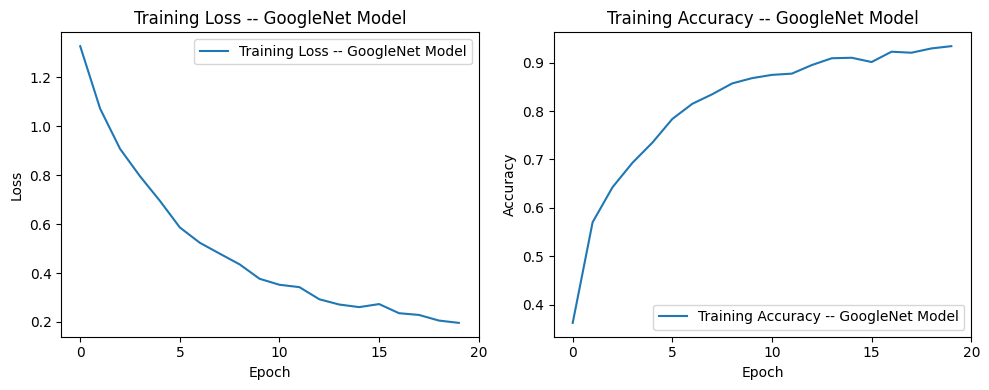

In [73]:
# Plot the training set loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(google_history.history['loss'], label='Training Loss -- GoogleNet Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss -- GoogleNet Model')
plt.xticks(np.linspace(0, 20, 5))
plt.legend()


# Plot the training set accuracy
plt.subplot(1, 2, 2)
plt.plot(google_history.history['accuracy'], label='Training Accuracy -- GoogleNet Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy -- GoogleNet Model')
plt.xticks(np.linspace(0, 20, 5))
plt.legend()

plt.tight_layout();
plt.show();

In [32]:
# Evaluate the model on the test set
google_model_predictions = google_model.predict(test_generator)

2024-03-06 14:47:01.027631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 36s 2s/step


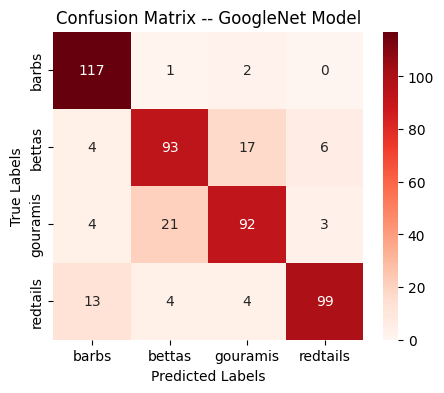

In [106]:
# Create confusion matrix
google_model_predicted_labels = np.argmax(google_model_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, google_model_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- GoogleNet Model')
plt.show();

In [34]:
# Count mislabeled images
# Get class names from folder names
class_names = sorted(os.listdir(dataset_path))

# Get true labels
true_labels = test_generator.classes

# Get predicted labels
google_model_predicted_labels = np.argmax(google_model_predictions, axis=1)

# Find mislabeled indices
google_model_mislabeled_indices = np.where(true_labels != google_model_predicted_labels)[0]

print("Number of mislabeled images:", len(google_model_mislabeled_indices))
print("Number of predictions:", len(google_model_predictions))
print("Overall accuracy:", round((1- (len(google_model_mislabeled_indices)/len(google_model_predictions)))*100, 2), "percent" )

Number of mislabeled images: 79
Number of predictions: 480
Overall accuracy: 83.54 percent


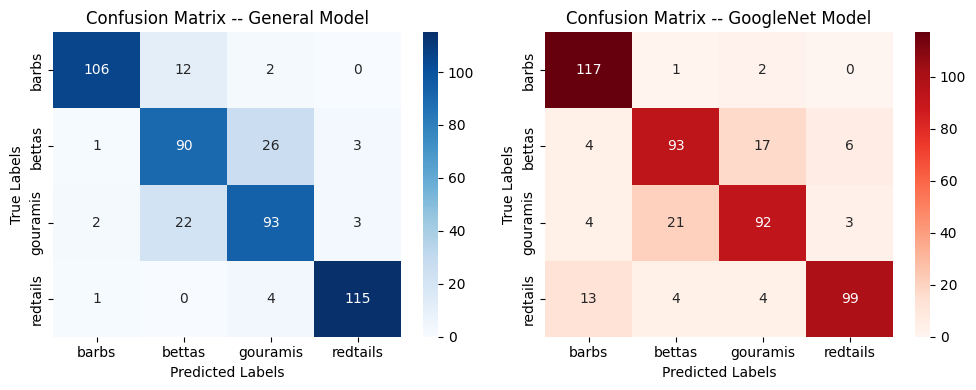

           Predictions  Errors Accuracy
Model                                  
General            480      76  84.17 %
GoogleNet          480      79  83.54 %


In [107]:
# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------
# SUMMARY OF PERFORMANCES FOR NON CROSSFOLD VALIDATION (CFV) GENERAL AND GOOGLENET MODEL VARIATIONS 
# -----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------- 

# General Model Confusion Matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
general_model_predicted_labels = np.argmax(general_model_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, general_model_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- General Model')


# GoogleNet Model Confusion Matrix
plt.subplot(1, 2, 2)
google_model_predicted_labels = np.argmax(google_model_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, google_model_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- GoogleNet Model')
plt.tight_layout();
plt.show();


general_accuracy = str(round((1- (len(general_mislabeled_indices)/len(general_model_predictions)))*100, 2)) + ' %'
google_accuracy = str(round((1- (len(google_model_mislabeled_indices)/len(google_model_predictions)))*100, 2)) + ' %'
# Organize Data
data = {'Model': ['General', 'GoogleNet'],
        'Predictions': [len(general_model_predictions), len(google_model_predictions)],
        'Errors': [len(general_mislabeled_indices), len(google_model_mislabeled_indices)],
        'Accuracy': [general_accuracy, google_accuracy]}
# Construct a DataFrame
df = pd.DataFrame.from_dict(data).set_index('Model')
# Display the DataFrame
print(df);


OBSERVATIONS FOR NON CROSSFOLD VALIDATION (CFV) MODEL VARIATIONS:

1-- Each model may be suffering from overfitting  
2-- Both models had dfiiculty separating bettas from gouramis  
3-- The general model also had trouble differentiating barbs from bettas (12 errors)  
4-- The googlenet model also had trouble differentiating redtails from barbs (13 errors)  
5-- For both models, each row contains 120 image predictions as expected   
 

In [127]:
# ---------------------------------------------------
# ---------------------------------------------------
# TRY CROSSFOLD VALIDATION (CFV) MODEL VARIATIONS
# ---------------------------------------------------
# ---------------------------------------------------

# List all classes (subdirectories) in the root directory
classes = [class_name for class_name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, class_name))]

# Define lists to store file paths and associated labels to set up cross validation
file_paths = []
labels = []

# Iterate over classes
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    
    # List all files in the class directory
    class_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith('.jpeg')]

    # Append file paths and labels to the lists
    file_paths.extend(class_files)
    labels.extend([class_name] * len(class_files))

# Create a DataFrame to store file paths and labels
df = pd.DataFrame({'Filepath': file_paths, 'Label': labels})

# Use train_test_split to split the DataFrame into training, validation, and test sets
# First, split the dataset: 80% into training and 20% into testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Then, further split the training set: 80%  into training set and 20% into validation set
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Set up ImageDataGenerator for  normalization
train_datagen_CFV = ImageDataGenerator(rescale=1./255) # Normalize pixel values to [0, 1]
val_datagen_CFV = ImageDataGenerator(rescale=1./255)
test_datagen_CFV = ImageDataGenerator(rescale=1./255)

# Set up generators for training, validation, and test sets
print('For Training Image Set:')
train_generator_CFV = train_datagen_CFV.flow_from_dataframe(dataframe=train_df, x_col='Filepath',
                                                     y_col='Label', target_size=(224, 224), 
                                                    batch_size=32, class_mode='categorical')
print('\nFor Validation Image Set:')
val_generator_CFV = val_datagen_CFV.flow_from_dataframe(dataframe=val_df, x_col='Filepath', 
                                                y_col='Label', target_size=(224, 224), 
                                                batch_size=32, class_mode='categorical')
print('\nFor Test Image Set:')
test_generator_CFV = test_datagen_CFV.flow_from_dataframe(dataframe=test_df, x_col='Filepath', y_col='Label', 
                                                  target_size=(224, 224), batch_size=32, 
                                                  class_mode='categorical', shuffle=False)


For Training Image Set:
Found 1536 validated image filenames belonging to 4 classes.

For Validation Image Set:
Found 384 validated image filenames belonging to 4 classes.

For Test Image Set:
Found 480 validated image filenames belonging to 4 classes.


In [111]:
# ---------------------------------------------------
# ---------------------------------------------------
# IMAGE CLASSIFICATION WITH GENERAL MODEL CFV 
# ---------------------------------------------------
# ---------------------------------------------------

# Define number of classes
Num_classes = 4
# Create the general CFV model
general_model_CFV = build_model(Num_classes)
# Compile Model
general_model_CFV.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, val_index in kf.split(train_df):
    train_set, val_set = train_df.iloc[train_index], train_df.iloc[val_index]

    # Train model using train_generator and validate on val_generator
    general_model_CFV_history = general_model_CFV.fit(train_generator_CFV, epochs=5, validation_data=val_generator_CFV)


Epoch 1/5


2024-03-06 21:04:20.221746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 1.3028 - accuracy: 0.3971

2024-03-06 21:04:51.438658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 33s 672ms/step - loss: 1.3028 - accuracy: 0.3971 - val_loss: 1.1855 - val_accuracy: 0.4531
Epoch 2/5
48/48 [==============================] - 31s 650ms/step - loss: 1.0415 - accuracy: 0.5553 - val_loss: 1.1058 - val_accuracy: 0.5260
Epoch 3/5
48/48 [==============================] - 31s 650ms/step - loss: 0.8891 - accuracy: 0.6465 - val_loss: 0.8289 - val_accuracy: 0.6536
Epoch 4/5
48/48 [==============================] - 34s 696ms/step - loss: 0.7201 - accuracy: 0.7324 - val_loss: 0.8210 - val_accuracy: 0.6927
Epoch 5/5
48/48 [==============================] - 32s 676ms/step - loss: 0.5687 - accuracy: 0.7923 - val_loss: 0.6554 - val_accuracy: 0.7448
Epoch 1/5


2024-03-06 21:07:09.057888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8438

2024-03-06 21:07:40.927708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 33s 693ms/step - loss: 0.4446 - accuracy: 0.8438 - val_loss: 0.5232 - val_accuracy: 0.7839
Epoch 2/5
48/48 [==============================] - 34s 707ms/step - loss: 0.4051 - accuracy: 0.8620 - val_loss: 0.4395 - val_accuracy: 0.8281
Epoch 3/5
48/48 [==============================] - 32s 677ms/step - loss: 0.3050 - accuracy: 0.8971 - val_loss: 0.3909 - val_accuracy: 0.8516
Epoch 4/5
48/48 [==============================] - 32s 679ms/step - loss: 0.2999 - accuracy: 0.8945 - val_loss: 0.3591 - val_accuracy: 0.8698
Epoch 5/5
48/48 [==============================] - 32s 662ms/step - loss: 0.2436 - accuracy: 0.9193 - val_loss: 0.3367 - val_accuracy: 0.8672
Epoch 1/5


2024-03-06 21:10:00.719636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9368

2024-03-06 21:10:30.124989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 31s 645ms/step - loss: 0.1898 - accuracy: 0.9368 - val_loss: 0.3427 - val_accuracy: 0.8828
Epoch 2/5
48/48 [==============================] - 33s 680ms/step - loss: 0.1692 - accuracy: 0.9466 - val_loss: 0.3265 - val_accuracy: 0.8724
Epoch 3/5
48/48 [==============================] - 31s 639ms/step - loss: 0.1488 - accuracy: 0.9512 - val_loss: 0.3620 - val_accuracy: 0.8542
Epoch 4/5
48/48 [==============================] - 31s 638ms/step - loss: 0.1316 - accuracy: 0.9590 - val_loss: 0.2912 - val_accuracy: 0.8932
Epoch 5/5
48/48 [==============================] - 33s 684ms/step - loss: 0.0942 - accuracy: 0.9720 - val_loss: 0.2905 - val_accuracy: 0.8828
Epoch 1/5


2024-03-06 21:13:07.128373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9831

2024-03-06 21:13:37.207336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 31s 656ms/step - loss: 0.0744 - accuracy: 0.9831 - val_loss: 0.2648 - val_accuracy: 0.8880
Epoch 2/5
48/48 [==============================] - 32s 662ms/step - loss: 0.0600 - accuracy: 0.9870 - val_loss: 0.2700 - val_accuracy: 0.8984
Epoch 3/5
48/48 [==============================] - 31s 638ms/step - loss: 0.0516 - accuracy: 0.9915 - val_loss: 0.2913 - val_accuracy: 0.8958
Epoch 4/5
48/48 [==============================] - 33s 682ms/step - loss: 0.0377 - accuracy: 0.9941 - val_loss: 0.3217 - val_accuracy: 0.8906
Epoch 5/5
48/48 [==============================] - 31s 644ms/step - loss: 0.0563 - accuracy: 0.9837 - val_loss: 0.3508 - val_accuracy: 0.8854
Epoch 1/5


2024-03-06 21:15:44.417507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9831

2024-03-06 21:16:14.998507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 32s 672ms/step - loss: 0.0563 - accuracy: 0.9831 - val_loss: 0.3100 - val_accuracy: 0.9036
Epoch 2/5
48/48 [==============================] - 31s 647ms/step - loss: 0.0295 - accuracy: 0.9987 - val_loss: 0.3033 - val_accuracy: 0.8984
Epoch 3/5
48/48 [==============================] - 30s 620ms/step - loss: 0.0224 - accuracy: 0.9980 - val_loss: 0.2887 - val_accuracy: 0.9089
Epoch 4/5
48/48 [==============================] - 31s 654ms/step - loss: 0.0163 - accuracy: 0.9987 - val_loss: 0.3648 - val_accuracy: 0.8854
Epoch 5/5
48/48 [==============================] - 33s 695ms/step - loss: 0.0297 - accuracy: 0.9948 - val_loss: 0.2999 - val_accuracy: 0.9089


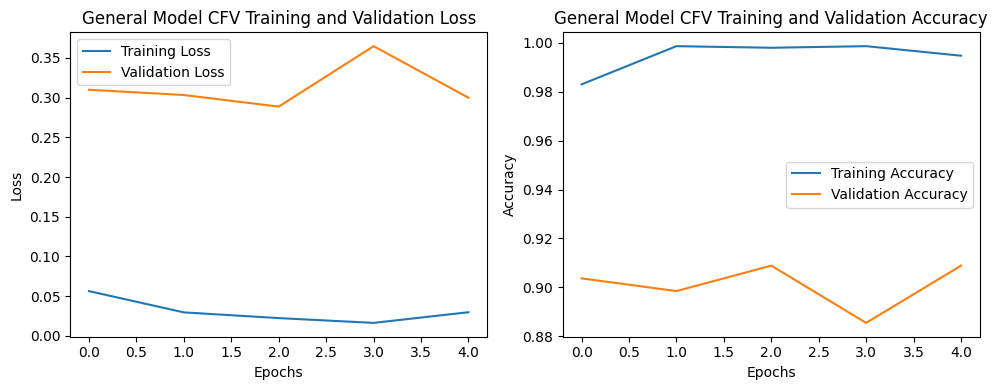

In [112]:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(general_model_CFV_history.history['loss'], label='Training Loss')
    plt.plot(general_model_CFV_history.history['val_loss'], label='Validation Loss')
    plt.title('General Model CFV Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(general_model_CFV_history.history['accuracy'], label='Training Accuracy')
    plt.plot(general_model_CFV_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('General Model CFV Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout();
    plt.show();

In [113]:
# Evaluate the model on the test set
general_model_CFV_predictions = general_model_CFV.predict(test_generator)

2024-03-06 21:46:13.459184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 2s 124ms/step


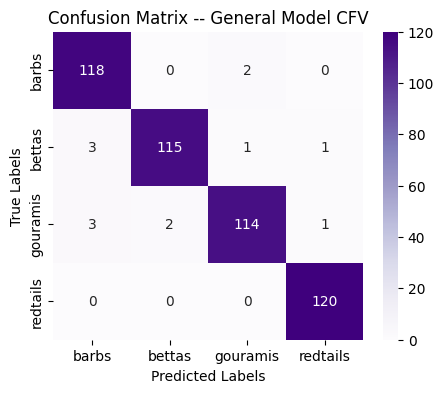

In [129]:
# Create confusion matrix
general_model_CFV_predicted_labels = np.argmax(general_model_CFV_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, general_model_CFV_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- General Model CFV')
plt.show();

In [115]:
# Count mislabeled images
# Get class names from folder names
class_names = sorted(os.listdir(dataset_path))

# Get true labels
true_labels = test_generator.classes

# Get predicted labels
general_model_CFV_predicted_labels = np.argmax(general_model_CFV_predictions, axis=1)

# Find mislabeled indices
general_model_CFV_mislabeled_indices = np.where(true_labels != general_model_CFV_predicted_labels)[0]

print("Number of mislabeled images:", len(general_model_CFV_mislabeled_indices))
print("Number of predictions:", len(general_model_CFV_predictions))
print("Overall accuracy:", round((1- (len(general_model_CFV_mislabeled_indices)/len(general_model_CFV_predictions)))*100, 2), "percent" )


Number of mislabeled images: 13
Number of predictions: 480
Overall accuracy: 97.29 percent


In [116]:
# ---------------------------------------------------
# ---------------------------------------------------
# IMAGE CLASSIFICATION WITH GOOGLENET MODEL CFV 
# ---------------------------------------------------
# ---------------------------------------------------

# Create the googlenet CFV model
googlenet_model_CFV = googlenet()
# Compile Model
googlenet_model_CFV.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, val_index in kf.split(train_df):
    train_set, val_set = train_df.iloc[train_index], train_df.iloc[val_index]

    # Train model using train_generator and validate on val_generator
    googlenet_model_CFV_history = googlenet_model_CFV.fit(train_generator_CFV, epochs=5, validation_data=val_generator_CFV)


Epoch 1/5


2024-03-06 21:47:32.957328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 1.3613 - accuracy: 0.3587

2024-03-06 21:53:44.064873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 399s 8s/step - loss: 1.3613 - accuracy: 0.3587 - val_loss: 1.3175 - val_accuracy: 0.5703
Epoch 2/5
48/48 [==============================] - 397s 8s/step - loss: 1.2228 - accuracy: 0.5534 - val_loss: 1.1703 - val_accuracy: 0.4688
Epoch 3/5
48/48 [==============================] - 398s 8s/step - loss: 1.0347 - accuracy: 0.5853 - val_loss: 0.9466 - val_accuracy: 0.6016
Epoch 4/5
48/48 [==============================] - 398s 8s/step - loss: 0.8494 - accuracy: 0.6686 - val_loss: 0.8986 - val_accuracy: 0.6068
Epoch 5/5
48/48 [==============================] - 394s 8s/step - loss: 0.7842 - accuracy: 0.7018 - val_loss: 0.8068 - val_accuracy: 0.6562
Epoch 1/5


2024-03-06 22:22:52.176890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.7409

2024-03-06 22:29:00.630462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 397s 8s/step - loss: 0.7019 - accuracy: 0.7409 - val_loss: 0.7218 - val_accuracy: 0.7135
Epoch 2/5
48/48 [==============================] - 391s 8s/step - loss: 0.5930 - accuracy: 0.7754 - val_loss: 0.6926 - val_accuracy: 0.7188
Epoch 3/5
48/48 [==============================] - 391s 8s/step - loss: 0.5368 - accuracy: 0.8092 - val_loss: 0.5970 - val_accuracy: 0.7734
Epoch 4/5
48/48 [==============================] - 394s 8s/step - loss: 0.4764 - accuracy: 0.8333 - val_loss: 0.5413 - val_accuracy: 0.8177
Epoch 5/5
48/48 [==============================] - 396s 8s/step - loss: 0.4557 - accuracy: 0.8464 - val_loss: 0.4995 - val_accuracy: 0.8359
Epoch 1/5


2024-03-06 22:58:05.283045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8444

2024-03-06 23:04:07.184683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 390s 8s/step - loss: 0.4217 - accuracy: 0.8444 - val_loss: 0.4810 - val_accuracy: 0.8255
Epoch 2/5
48/48 [==============================] - 395s 8s/step - loss: 0.3898 - accuracy: 0.8646 - val_loss: 0.5265 - val_accuracy: 0.7969
Epoch 3/5
48/48 [==============================] - 395s 8s/step - loss: 0.3509 - accuracy: 0.8841 - val_loss: 0.4515 - val_accuracy: 0.8385
Epoch 4/5
48/48 [==============================] - 394s 8s/step - loss: 0.3556 - accuracy: 0.8763 - val_loss: 0.4831 - val_accuracy: 0.8099
Epoch 5/5
48/48 [==============================] - 396s 8s/step - loss: 0.3281 - accuracy: 0.8848 - val_loss: 0.4138 - val_accuracy: 0.8411
Epoch 1/5


2024-03-06 23:34:09.206017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8672

2024-03-06 23:40:16.021625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 396s 8s/step - loss: 0.3631 - accuracy: 0.8672 - val_loss: 0.3982 - val_accuracy: 0.8333
Epoch 2/5
48/48 [==============================] - 393s 8s/step - loss: 0.3186 - accuracy: 0.8828 - val_loss: 0.4197 - val_accuracy: 0.8464
Epoch 3/5
48/48 [==============================] - 395s 8s/step - loss: 0.2723 - accuracy: 0.9062 - val_loss: 0.3921 - val_accuracy: 0.8516
Epoch 4/5
48/48 [==============================] - 408s 8s/step - loss: 0.2504 - accuracy: 0.9128 - val_loss: 0.3848 - val_accuracy: 0.8490
Epoch 5/5
48/48 [==============================] - 406s 8s/step - loss: 0.2481 - accuracy: 0.9167 - val_loss: 0.4311 - val_accuracy: 0.8359
Epoch 1/5


2024-03-07 00:09:49.679834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9186

2024-03-07 00:16:02.251971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 401s 8s/step - loss: 0.2325 - accuracy: 0.9186 - val_loss: 0.3606 - val_accuracy: 0.8568
Epoch 2/5
48/48 [==============================] - 396s 8s/step - loss: 0.2185 - accuracy: 0.9264 - val_loss: 0.3893 - val_accuracy: 0.8516
Epoch 3/5
48/48 [==============================] - 393s 8s/step - loss: 0.2054 - accuracy: 0.9264 - val_loss: 0.3670 - val_accuracy: 0.8698
Epoch 4/5
48/48 [==============================] - 391s 8s/step - loss: 0.2167 - accuracy: 0.9238 - val_loss: 0.3323 - val_accuracy: 0.8802
Epoch 5/5
48/48 [==============================] - 391s 8s/step - loss: 0.1988 - accuracy: 0.9316 - val_loss: 0.3496 - val_accuracy: 0.8750


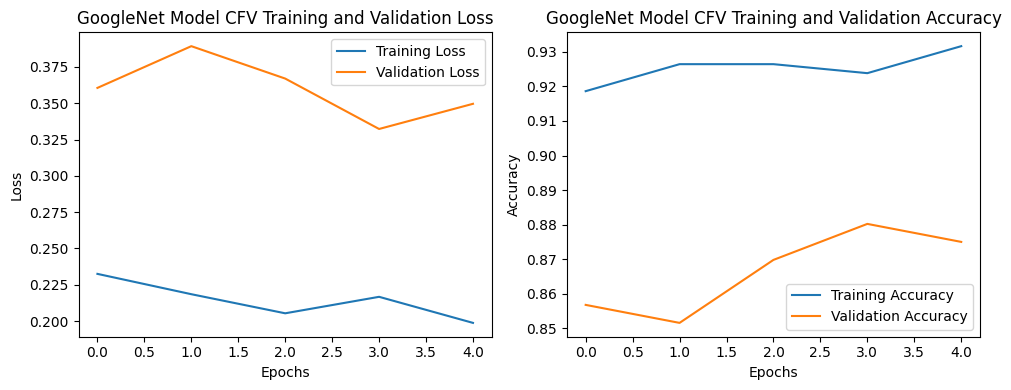

In [117]:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(googlenet_model_CFV_history.history['loss'], label='Training Loss')
    plt.plot(googlenet_model_CFV_history.history['val_loss'], label='Validation Loss')
    plt.title('GoogleNet Model CFV Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(googlenet_model_CFV_history.history['accuracy'], label='Training Accuracy')
    plt.plot(googlenet_model_CFV_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('GoogleNet Model CFV Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout();
    plt.show();

In [118]:
# Evaluate the model on the test set
googlenet_model_CFV_predictions = googlenet_model_CFV.predict(test_generator)

2024-03-07 00:50:42.224899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 35s 2s/step


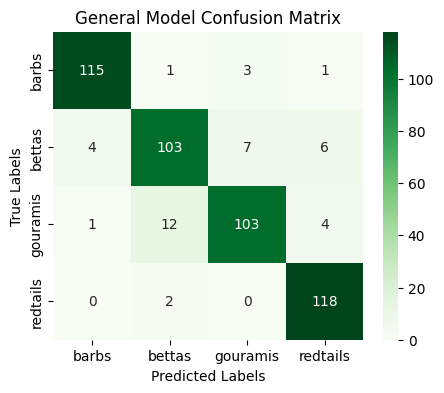

In [119]:
# Create confusion matrix
googlenet_model_CFV_predicted_labels = np.argmax(googlenet_model_CFV_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, googlenet_model_CFV_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('General Model Confusion Matrix')
plt.show();

In [120]:
# Count mislabeled images
# Get class names from folder names
class_names = sorted(os.listdir(dataset_path))

# Get true labels
true_labels = test_generator.classes

# Get predicted labels
googlenet_model_CFV_predicted_labels = np.argmax(googlenet_model_CFV_predictions, axis=1)

# Find mislabeled indices
googlenet_model_CFV_mislabeled_indices = np.where(true_labels != googlenet_model_CFV_predicted_labels)[0]

print("Number of mislabeled images:", len(googlenet_model_CFV_mislabeled_indices))
print("Number of predictions:", len(googlenet_model_CFV_predictions))
print("Overall accuracy:", round((1- (len(googlenet_model_CFV_mislabeled_indices)/len(googlenet_model_CFV_predictions)))*100, 2), "percent" )

Number of mislabeled images: 41
Number of predictions: 480
Overall accuracy: 91.46 percent


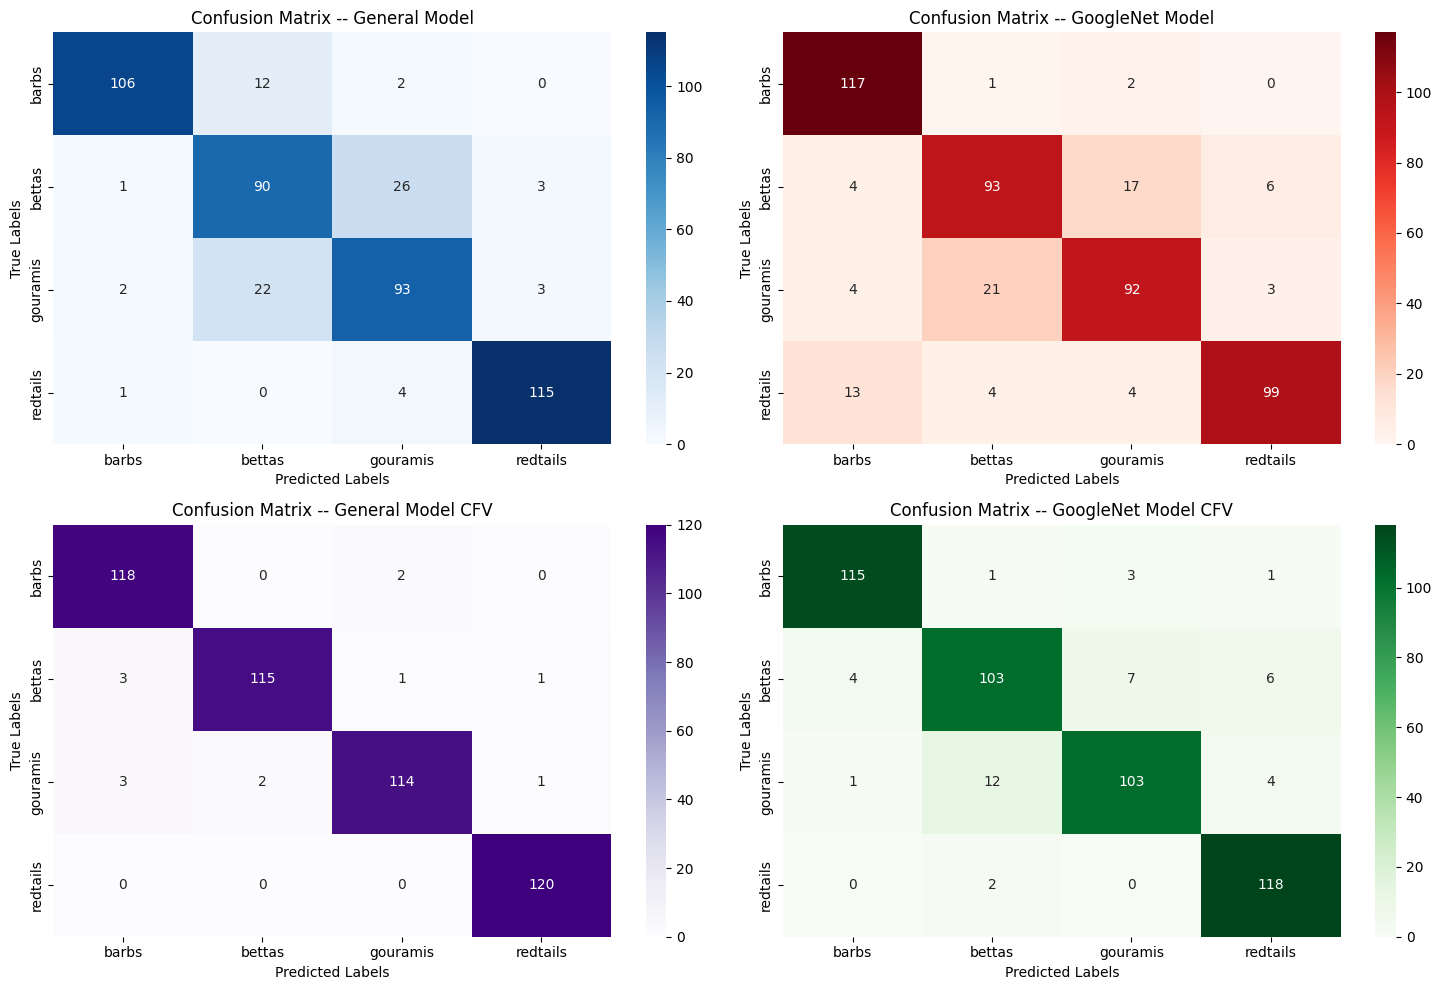

               Predictions  Errors Accuracy
Model                                      
General                480      76  84.17 %
GoogleNet              480      79  83.54 %
General CFV            480      13  97.29 %
GoogleNet CFV          480      41  91.46 %


In [131]:
# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------
# SUMMARY OF PERFORMANCES FOR NON CROSSFOLD VALIDATION (CFV) GENERAL AND GOOGLENET MODEL VARIATIONS 
# SUMMARY OF PERFORMANCES FOR CROSSFOLD VALIDATION (CFV) GENERAL AND GOOGLENET MODEL VARIATIONS 
# -----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------- 

# General Model Confusion Matrix
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
general_model_predicted_labels = np.argmax(general_model_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, general_model_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- General Model')


# GoogleNet Model Confusion Matrix
plt.subplot(2, 2, 2)
google_model_predicted_labels = np.argmax(google_model_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, google_model_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- GoogleNet Model')


# General Model CFV Confusion Matrix
plt.subplot(2, 2, 3)
general_model_CFV_predicted_labels = np.argmax(general_model_CFV_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, general_model_CFV_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- General Model CFV')


# GoogleNet Model CFV Confusion Matrix
plt.subplot(2, 2, 4)
googlenet_model_CFV_predicted_labels = np.argmax(googlenet_model_CFV_predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, googlenet_model_CFV_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -- GoogleNet Model CFV')

plt.tight_layout();
plt.show();

general_accuracy = str(round((1- (len(general_mislabeled_indices)/len(general_model_predictions)))*100, 2)) + ' %'
google_accuracy = str(round((1- (len(google_model_mislabeled_indices)/len(google_model_predictions)))*100, 2)) + ' %'
general_CFV_accuracy = str(round((1- (len(general_model_CFV_mislabeled_indices)/len(general_model_CFV_predictions)))*100, 2)) + ' %'
google_CFV_accuracy = str(round((1- (len(googlenet_model_CFV_mislabeled_indices)/len(googlenet_model_CFV_predictions)))*100, 2)) + ' %'
# Organize Data
data = {'Model': ['General', 
                  'GoogleNet',
                  'General CFV',
                  'GoogleNet CFV',
                 ],
        'Predictions': [len(general_model_predictions), 
                        len(google_model_predictions),
                        len(general_model_CFV_predictions),
                        len(googlenet_model_CFV_predictions),
                       ],
        'Errors': [len(general_mislabeled_indices), 
                   len(google_model_mislabeled_indices),
                   len(general_model_CFV_mislabeled_indices),
                   len(googlenet_model_CFV_mislabeled_indices)
                  ],
        'Accuracy': [general_accuracy, 
                     google_accuracy,
                     general_CFV_accuracy,
                     google_CFV_accuracy,
                    ]}
# Construct a DataFrame
df = pd.DataFrame.from_dict(data).set_index('Model')
# Display the DataFrame
print(df);

OBSERVATIONS FOR ALL MODEL VARIATIONS:

1-- Using crossfold validation (CFV) improved both general and googlenet model accuracies  
2-- Even after CFV, the googlenet model still had trouble differentiating gouramis from bettas (12 errors)  
3-- The general model with CFV ("General Model CFV") seems to be the best model  
4-- For both models, each row contains 120 image predictions as expected  

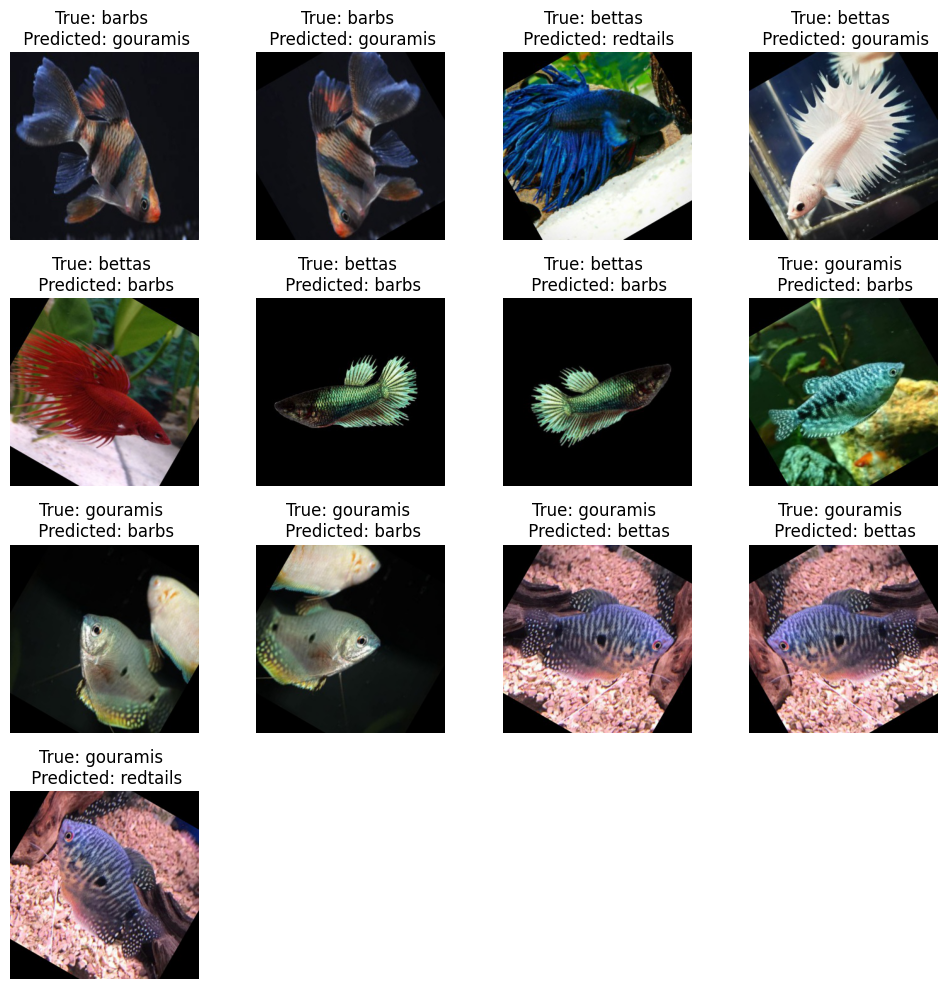

In [139]:
# Display all mislabeled images with class names for model with best performance ("General Model CFV")
plt.figure(figsize=(10,10))   
for i in range(0, len(general_model_CFV_mislabeled_indices)):
    index = general_model_CFV_mislabeled_indices[i]
    true_label_index = true_labels[index]
    predicted_label_index = general_model_CFV_predicted_labels[index]

    img_path = test_generator.filepaths[index]
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f'True: {class_names[true_label_index]} \n Predicted: {class_names[predicted_label_index]}')
    plt.axis('off')
plt.tight_layout()
plt.show();